<a href="https://colab.research.google.com/github/AmberMynott/AmberMynott-DataScience-GenAI-Submissions/blob/main/Assessement_practice/ML_model_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I have uploaded the data set into the colab and now need to put this into a data frame. I'm going to do this using genai and the prompt "create a dataframe from loan_data.csv"

In [3]:
import pandas as pd

# Create a dataframe from loan_data.csv
df = pd.read_csv('loan_data.csv')

# Display the first few rows of the dataframe
print(df.head())

   age  years_employed  annual_income  credit_score  credit_history_years  \
0   40            17.2          25579           692                   5.3   
1   33             7.3          43087           627                   3.5   
2   42             1.1          20840           689                   8.4   
3   53             0.5          29147           692                   9.8   
4   32            12.5          63657           630                   7.2   

   savings_assets  current_debt  defaults_on_file  delinquencies_last_2yrs  \
0             895         10820                 0                        0   
1             169         16550                 0                        1   
2              17          7852                 0                        0   
3            1480         11603                 0                        1   
4             209         12424                 0                        0   

   derogatory_marks  loan_amount  interest_rate  debt_to_income_rati

This all looks ok, so I am now going to start building my model, by first splitting my data into X and Y values and training and testing data. First I'm going to normalise the data using code from https://github.com/MJMortensonWarwick/IB2AD0_Data_Science_GenerativeAI/blob/main/4_01_Decision_Trees.ipynb

In [4]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Create a DataFrame of features (x_values) by dropping the target column 'loan_status'
x_values = df.drop(columns=['loan_status'])

# create a MinMaxScaler object
scaler = MinMaxScaler()

# fit and transform the data
normal_data = scaler.fit_transform(x_values)

# recreate x_values using the scaled data and original feature names
x_values = pd.DataFrame(normal_data, columns=x_values.columns)

# create y value (target variable)
y_value = df['loan_status']
y_value = np.ravel(y_value)

Now that the data has been split into the X values and the y value, we can now split the data into test and training data.

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_values, y_value, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (40000, 15)
X_test shape: (10000, 15)
y_train shape: (40000,)
y_test shape: (10000,)


Everything looks ok from here.

I'm first going to create a decision tree WITHOUT ajusting any of the hyperparameters.

In [6]:
from sklearn.tree import DecisionTreeClassifier as DTC

# create the model
DTC_algo = DTC()
DTC_algo

DecisionTreeClassifier()

In [7]:
DTC_model = DTC_algo.fit(X_train, y_train)
DTC_model

DecisionTreeClassifier()

Now we have created our model, we need to see how well it has performed.

In [8]:
from sklearn.metrics import accuracy_score

# predict the test data
predict = DTC_model.predict(X_test)

# seperate the first five predictions and the first five real values in Y_test
for i in range(5):
  print(f'Predicted: {round(predict[i],2)}')
  print(f'Real: {y_test[i]}')
  print("\n")

print("\n")

print(f'Accuracy: {round(accuracy_score(y_test, predict),2)}')

Predicted: 1
Real: 1


Predicted: 1
Real: 1


Predicted: 0
Real: 0


Predicted: 0
Real: 0


Predicted: 1
Real: 1




Accuracy: 0.84


We currently have an accuracy of 84%, so it is perfoming pretty well.

Now let's look at the confusion matrix to see where the errors in the model are occurring.

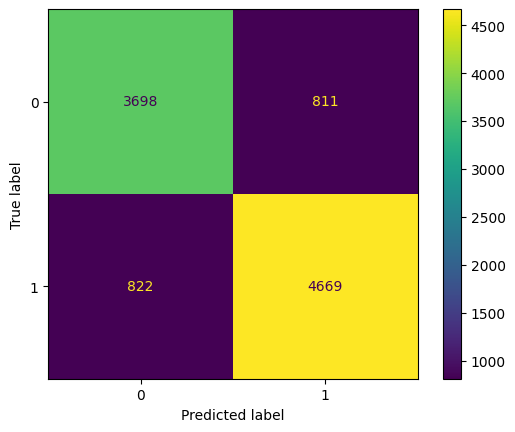

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay as CM

# create a confusion matrix
CM.from_predictions(y_test, predict)

From this confusion matrix, it appears that the model incorrectly predicts 0 slightly more frequently than it incorrectly predicts 1. Let's see if this reflects the proportion of 0s and 1s in the true dataset. I'm going to do this using genai using the prompt "Count how many 0s and 1s occur in the loan_status column in the df dataframe".

In [10]:
print(df['loan_status'].value_counts())

loan_status
1    27523
0    22477
Name: count, dtype: int64


As expected from our model's results, there are slightly more 0s than 1s in the loan_status column of our data frame.

To evaluate our model further, we can look at the precision, recall and F1 score.

In [11]:

from sklearn.metrics import precision_recall_fscore_support

# Calculate precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, predict, average='micro')

print(f"Micro-averaged Precision: {round(precision, 2)}")
print(f"Micro-averaged Recall: {round(recall, 2)}")
print(f"Micro-averaged F1-score: {round(f1_score, 2)}")
print("\n")

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, predict, average='macro')

print(f"Macro-averaged Precision: {round(precision, 2)}")
print(f"Macro-averaged Recall: {round(recall, 2)}")
print(f"Macro-averaged F1-score: {round(f1_score, 2)}")

Micro-averaged Precision: 0.84
Micro-averaged Recall: 0.84
Micro-averaged F1-score: 0.84


Macro-averaged Precision: 0.84
Macro-averaged Recall: 0.84
Macro-averaged F1-score: 0.84


We can further look at the decision tree associated with this model:

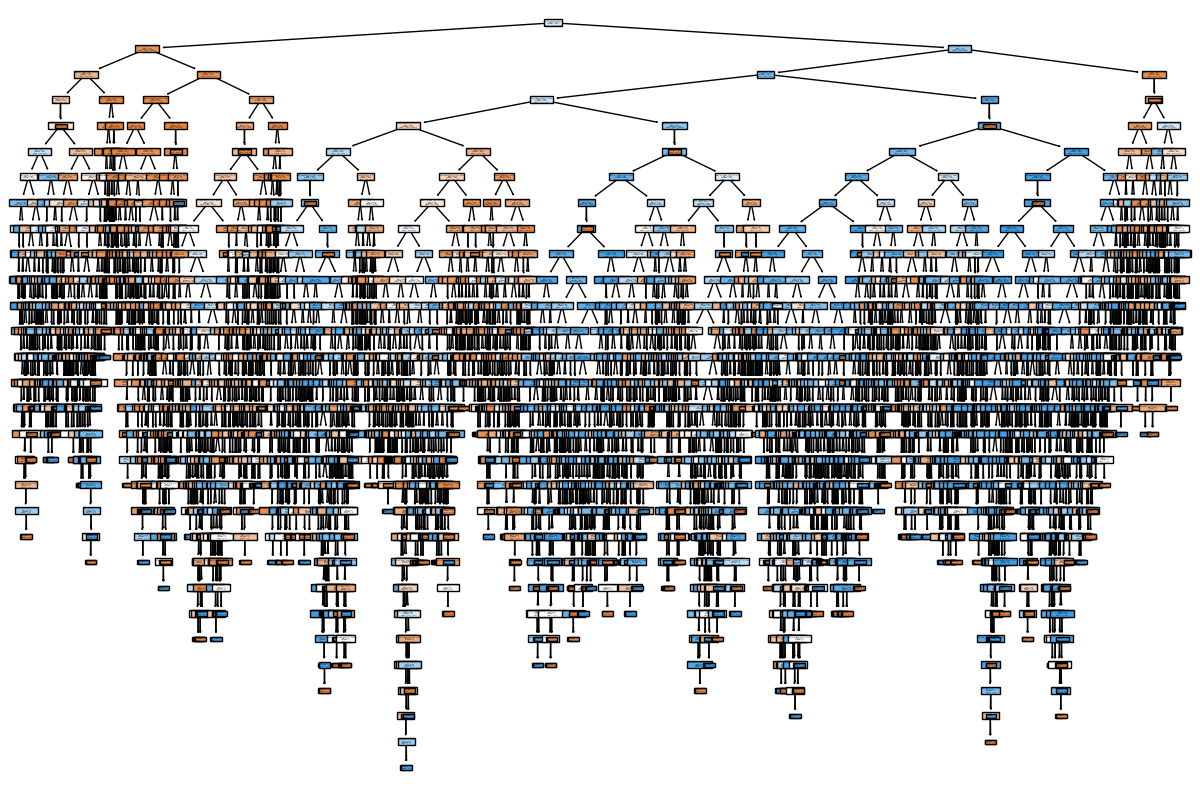

In [13]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
plot_tree(DTC_model, filled=True, feature_names=X_train.columns)
plt.show()

This tree clearly has far too many branches so we definitely have some overfitting happening here. In order to reduce this overfitting, we can use regularisation. To do this, we can search our hyperparameters to see what would be best to change.

In [14]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# this is the list of parameters we will tune. Some are fixed values some are distributions
tuned_parameters = {
    'criterion': ['gini', 'entropy'],
    'max_depth': randint(3, 9),  # Draw from a uniform distribution between 3 and 15
    'min_samples_split': randint(3, 9),  # Draw from a uniform distribution between 2 and 10
    'max_features': ['sqrt', 'log2', None]
}

# we will tune against f1_macro (to find the best choice)
score = 'f1_macro' # arbitrary choice

print(f"Tuning hyperparameters for {score}")
print("\n")

# do the search using 5 folds/chunks
clf = RandomizedSearchCV(DTC(), tuned_parameters, cv=5, random_state=1984,
                         scoring= score, n_iter=20, refit=True)

# pass the data to fit/train
clf.fit(X_train, y_train)

print("Best parameters set found on the training set:")
print(clf.best_params_)

Tuning hyperparameters for f1_macro


Best parameters set found on the training set:
{'criterion': 'entropy', 'max_depth': 8, 'max_features': None, 'min_samples_split': 7}


Now we have done this, we can retrain our model.

In [15]:
DTC_algo = DTC(**clf.best_params_) # get the best parameters from grid search
DTC_model = DTC_algo.fit(X_train, y_train)

Now we can predict our data again

In [16]:
# predict the test data
predict = DTC_model.predict(X_test)

# seperate the first five predictions and the first five real values in Y_test
for i in range(5):
  print(f'Predicted: {round(predict[i],2)}')
  print(f'Real: {y_test[i]}')
  print("\n")

print("\n")

print(f'Accuracy: {round(accuracy_score(y_test, predict),2)}')

Predicted: 1
Real: 1


Predicted: 1
Real: 1


Predicted: 0
Real: 0


Predicted: 0
Real: 0


Predicted: 1
Real: 1




Accuracy: 0.86


Our accuracy before we refined the model was 0.84 but it's now 0.86 so our accuracy has improved!


Now let's see whether recall, precision or F1 score have improved. We'd expect F1 score to improve since this is the hyperparameter we have fine tuned in this new model.

Micro-averaged Precision: 0.86
Micro-averaged Recall: 0.86
Micro-averaged F1-score: 0.86


Macro-averaged Precision: 0.87
Macro-averaged Recall: 0.86
Macro-averaged F1-score: 0.86




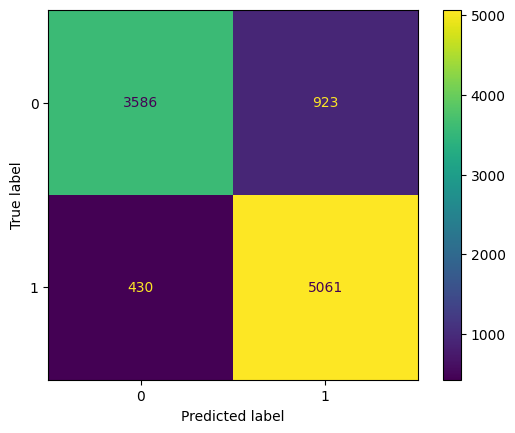

In [17]:
# create a confusion matrix
CM.from_predictions(y_test, predict)

# Calculate precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, predict, average='micro')

print(f"Micro-averaged Precision: {round(precision, 2)}")
print(f"Micro-averaged Recall: {round(recall, 2)}")
print(f"Micro-averaged F1-score: {round(f1_score, 2)}")
print("\n")

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, predict, average='macro')

print(f"Macro-averaged Precision: {round(precision, 2)}")
print(f"Macro-averaged Recall: {round(recall, 2)}")
print(f"Macro-averaged F1-score: {round(f1_score, 2)}")
print("\n")

As expected, our F1 macro score has improved. In fact, all our micro and macro recall, precision and F1 scores have improved!

However, one thing to note here is that while the number of 0s that were predicted incorrectly has massively reduced, the number of 1s that were incorrectly predicted has actually increased up to 923. With more time, this is something I would investigate further.

Now let's check the decision tree to see if there's evidence of less overfitting.

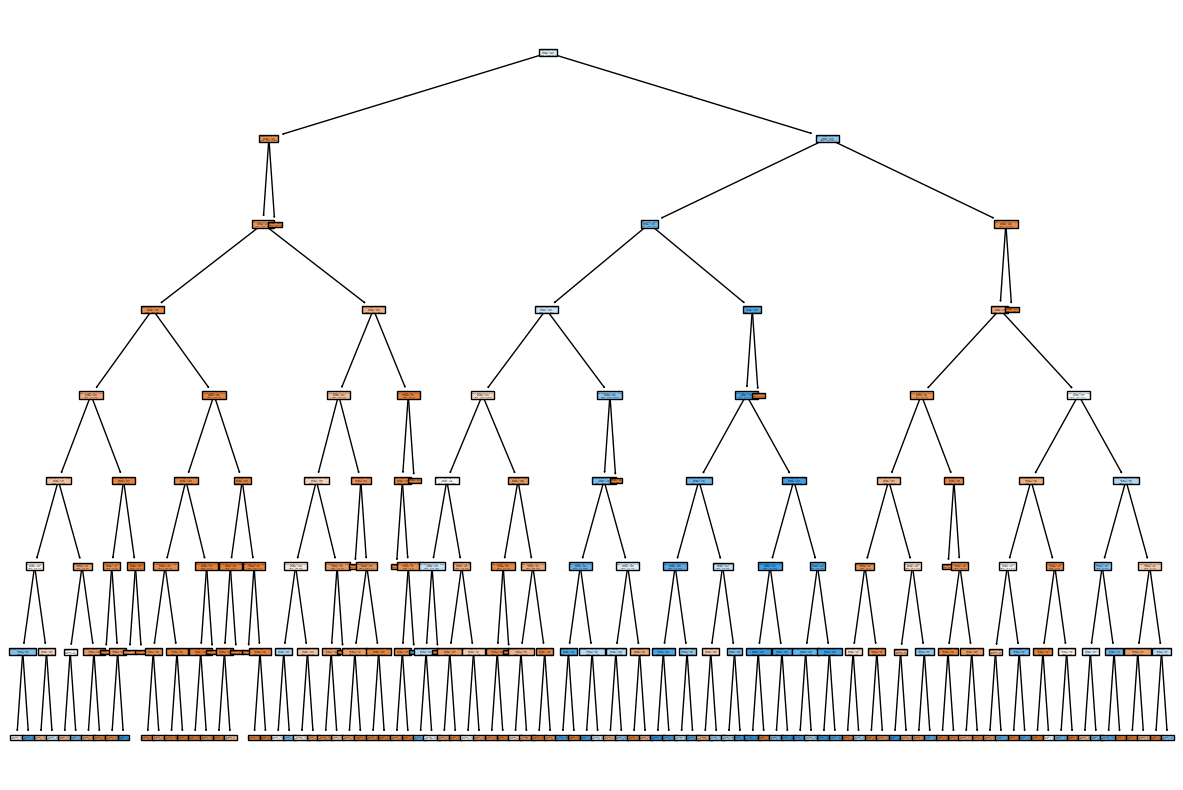

In [18]:
plt.figure(figsize=(15, 10))
plot_tree(DTC_model, filled=True, feature_names=X_train.columns)
plt.show()

While this tree still shows significant evidence of overfitting, it is a lot better than our original tree.

Since we still have overfitting, with more time available, I would utilise random forests and GBDT to further hyperparameter tune this model.